# 11.3 Faster Optimizers オプティマイザーの高速化

## はじめに

### 目的 

勾配降下法オプティマイザよりも高速なオプティマイザを利用する

### 注意点

各種参考文献でモーメンタムとβの符号が混乱しているので注意すること
参考文献の２つめのネット情報が分かりやすく直感的に見える。

実践機械学習は、あるw(i,j,k...)の座標から、モーメンタムmを足すとなっているが、
図をかいた時のわかりやすさを重視し、パラメータの符号を変え整合性がとれるようにした。

- 教科書, Adamの符号が間違っているように見える
- 下記紹介している Youtube, Nagの括弧の中の符号が間違っている + でなくて、負


### 参考

- 1. https://www.youtube.com/watch?v=q933reMpvX8
    - このYoutubeはNAGのgradの中のβの符号が間違っているので注意、もしかしてNagの挙動も間違っているかも
- 2. https://pystyle.info/pytorch-sgd/ (これが一番正確で分かりやすいと思う)

In [40]:
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

## 復習: SGD

$$
\begin{align}
&w^{t+1} = w^t - \eta \triangledown_wE\left(w^t\right) 　\\
\end{align}
$$

重み関数が一つ、誤差関数をコスト関数(Error)を2時間数と過程したときで理解

In [51]:
def create_tangent_line(xj, yj, a):
    b = yj - a + xj
    xi = xj - 1
    xk = xj + 1
    yi = a * xi + b
    yk = a * xk + b
    x = [xi, xj, xk]
    y = [yi, yj, yk]
    return x, y
    
def delta_x(eta, x):
    return 2 * eta * x

def square(x):
    return x**2

<function matplotlib.pyplot.show(close=None, block=None)>

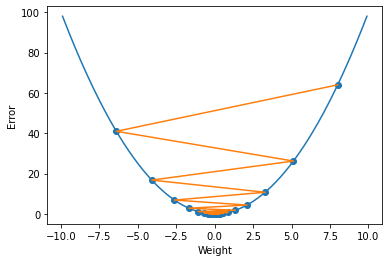

In [80]:
eta = 0.9
xinit = 8
u = np.array(range(1,200))
x_guide = 0.1 * u - 10
y_guide = x_guide**2
a = 2*x

iter = 30
x = xinit
y = square(xinit)
xlist = []
ylist = []
for val in range(iter):
    xlist.append(x)
    ylist.append(y)
    x = x - delta_x(eta, x)
    y = square(x)

plt.plot(x_guide, y_guide)
plt.scatter(xlist, ylist)
plt.plot(xlist, ylist)
plt.xlabel("Weight")
plt.ylabel("Error")
plt.show

## 11.3.1 Momentum optimization (Momentum SGD)

- MomentumSGDは慣性をもたせた手法
- https://www.youtube.com/watch?v=q933reMpvX8
    - 6:12 - 9:22 を参照


![](https://docs.google.com/drawings/d/e/2PACX-1vQpQaX6DfO3PYIvrHg6YnLNilhtEq9nSVa_4eW5RtMiVfLd0SoKwiIyfsS3g1VKS8A-5dZWgiFuAJwI/pub?w=897&h=499)

$$
\begin{align}
&m^{t} = \beta m^{t-1} - \eta \triangledown_wE\left(w^{t}\right) 　\\
&w^{t+1} = w^t+m^{t}
\end{align}
$$


つまり以下のようになる。
$$
\begin{align}
&w^{t+1} = w^{t} + \beta m^{t-1} - \eta \triangledown_wE\left(w^t\right)
\end{align}
$$

- SGDと比較して `βm` が付与されいる。`β`がゼロの時はSGDと完全に一致する。過去の勾配情報を引きずりながら、収束する動作となる
- 副次的な利点として、慣性で局所最適点を超えていく可能正もある。
- オーバーシュートの問題がある

In [41]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

## 11.3.2 NAG (Nesterov Accelerated Gradient)

- 勾配を計算する場所を変える。(ω+βm) が最終的に出てくるのだから、gradするのもこの位置でやるのが妥当だろう。
- これにより、Momentum SGDのオーバーシュートの問題を解決する
- https://www.youtube.com/watch?v=q933reMpvX8
    - このYoutubeのNAGの紹介は一部まちがっており、作者の符号のとり方だと ω-βm が正解となることに注意。挙動も違っているかも・・・)
    - 9:17 - 10:33

![](https://docs.google.com/drawings/d/e/2PACX-1vSmxkeaa31-zz4zRe-RW-kzVe3lnL5yaEkZjAiVo9ltHom8HFu9jWU98cG56hWIFe2wt8LeXG6kblWa/pub?w=897&h=499)

$$
\begin{align}
&m^{t} = \beta m^{t-1} - \eta \triangledown_wE\left(w^t+\beta m^{t-1}\right) 　\\
&w^{t+1} = w^t+m^{t}
\end{align}
$$


つまり、以下のようになる。同じ位置で微分していることが分かるように、わざと括弧をつけていることに着目

$$
\begin{align}
&w^{t+1} = \left(w^t + \beta m^{t-1}\right) - \eta \triangledown_wE\left(w^t+\beta m^{t-1}\right) 　\\
\end{align}
$$

w(t)-βm進めると傾きが反転する場合、MomentumにくらべてNagはいち早くこの傾き反転を反映できるため、オーバーシュートが少なくなる

In [42]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

## 11.3.3 AddGrad

早い段階で全体の最適値の方に向きを修正できる.もっとも影響力のある次元(重みパラメータ)を弱体化するイメージ
変動する学習率とも考えることができる。

- 最初の項で、傾きが大きい次元が2乗されることで、大きい値はより大きくなる
- 第2項を見ると、これは学習率が動的に変化すると考えることができる。
    - 傾きが急だと学習率が下がる=>傾きが緩やかな方にボールが転がる、つまり最適解のほうへベクトルが向いていることに等しい
        - 傾きが急なところはゆっくり収束させる
        - 傾きがゆるやかなところは一気に進ませる
- 早すぎる段階でスローダウンし、全体の最適解に収束しない場合がある
- εはゼロ割を防ぐための定数

![](https://docs.google.com/drawings/d/e/2PACX-1vTG7oBzUksKj_ltEVzxqV0iafuks2-dYwE8ryEywdwsVh3ZV1QUgdM0bh8Esz_f_BTq9sUr8k6X9O9w/pub?w=729&h=452)

$$
\begin{align}
&s^{t+1} = \beta s^t + \triangledown_wE\left(w^t\right)\otimes \triangledown_wE\left(w^t\right)　\\
&w^{t+1} = w^t-\eta \triangledown_wE\left(w^t\right) \oslash \sqrt{s+\epsilon}
\end{align}
$$

In [43]:
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

## 11.3.4 RMSProp

- AddGradの改良。AddGradの問題点 「早すぎる段階でスローダウンし、全体の最適解に収束しない場合がある」 を改善。
    - AddGradの問題点のイメージとしては、最短の方向を向いたものの、スピードがでないイメージ。傾きが大きいところの実質的な学習率は下がるため
- (1-β)とすることで、できるだけ直近の勾配の影響のみ影響を与えるようにしている
- β = 1とするとSGDの式とほとんど同じ η/ε = η' と考えることでSGDと同じになる
- εはゼロ割を防ぐための定数
- fdsasdf
    - 10:34 - 13:32

$$
\begin{align}
&s^{t+1} = \beta s^t + \left(1-\beta\right)\triangledown_wE\left(w^t\right)\otimes \triangledown_wE\left(w^t\right)　\\
&w^{t+1} = w^t-\eta \triangledown_wE\left(w^t\right) \oslash \sqrt{s+\epsilon}
\end{align}
$$

In [44]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

## 11.3.5 Adam, Nadam

### Adam (Adaptive moment estimation)

- モーメンタム最適化とRMSPropのアイデアを組み合わせたもの
- 学習開始初期はm, sの値が大きくなるようにしている。βが0.9の場合、開始直後 m_hatは10倍になる
- β1は0.9, β2は0.999で初期化されることが多い, εは10^-7くらいの大きさが多い
- ηは実質的に自動調整されることになるが、通常0.001を与えることがおおい
- https://www.youtube.com/watch?v=q933reMpvX8
    - 13:35 - 16:57

$$
\begin{align}
&m^{t+1} = \beta_1 m^t - \left(1-\beta_1\right)\triangledown_wE\left(w^t\right) \\
&s^{t+1} = \beta_2 s^t + \left(1-\beta_2\right)\triangledown_wE\left(w^t\right)\otimes \triangledown_wE\left(w^t\right)　\\
&\hat{m}^{t+1} = \frac{m^{t+1}}{1-{\beta_1}^{t}} \\
&\hat{s}^{t+1} = \frac{s^{t+1}}{1-{\beta_2}^{t}} \\
&w^{t+1} = w^t+\eta\hat{m}^{t+1} \oslash \sqrt{s+\epsilon}
\end{align}
$$

### AdaMax

式の詳細は省略するが、以下を記憶にとどめておくと良い

- 一般的にはAdamのほうが性能が高い
- Adamで問題起きた時この手法を試せば良い

In [45]:
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

### Nadam

一言でいうと、Adam + Nag

- Adamより少しはやく収束することが多い
- しばしば性能はRMSPropに負ける


In [46]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

### 注意事項

- RMSProp, Adam, Nadam はよい解に速く収束し上手く機能することが多い。しかし、汎化性能が十分でない可能性があり。
- モデルの性能が上がらなかったときはプレーンなNAGを試す

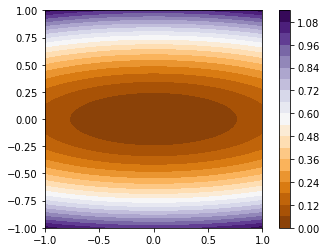

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


def f(x, y):
    a1 = 0.1
    a2 = 1
    #z = -np.exp(-(a1*X**2 + a2*Y**2))
    z = a1 * x**2 + a2 * y**2
    return z

x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

fig, ax = plt.subplots()
contf = ax.contourf(X, Y, Z, 20, cmap='PuOr')
ax.set_aspect('equal','box')
plt.colorbar(contf)
plt.savefig("contourf_PuOr.png", bbox_inches = 'tight', pad_inches = 0.1)